# Functionality walk-through

<div style="width: 600px;">
This notebook walks through how to use the functionality of the PPA analysis tool through it's Python APIs.
</div>
<br>
<div style="width: 600px;">
While interface.ipynb provides a convenient way for users to get started using the tool, advanced users 
requiring more flexibility or wishing to automate or batch the analysis may find it better to use the
functionality directly through the provided Python functions.
</div>
<br>
<div style="width: 600px;">
This notebook aims to help the user understand how to complete an analysis using the tool's Python
functions by providing a walk-through of how to use the functions in an analysis pipeline, starting
with data loading and continuing all the way through to bill calculation.
</div>

## Table of contents

1. Data loading
    1. Load data
    2. Generation data
    3. Price data
    4. Emissions data
2. Firming costs
3. LCOE calculations
4. Contract optimisation
5. Battery operation
6. Load flexibility
7. Bill calculation

In [33]:
# Firstly we'll just turn off NEMOSIS warnings to keep things clean

import logging

logging.getLogger("nemosis").setLevel(logging.ERROR)


## 1. Data loading

<div style="width: 600px;">
The sections below, Generation data, Price data, Load data, and Emissions data 
show how the tool's inbuilt functionality can be used to prepare datasets for
PPA analysis and modelling. However, the output in the below examples also 
provides a good guide as to the data formats required by the tool for users
wishing to prepare their own datasets.
</div>

<br>

<div style="width: 600px;">
Firstly, we define a few common parameters we'll use for the various data preparation steps and import the tool advanced settings, which define where various types of data are stored.
</div>

In [34]:
from datetime import datetime

from ppa_analysis import advanced_settings, import_data

start_date = '2020-01-01 00:00:00'
end_date = '2020-02-01 00:00:00'

# times need to be given to PPA analysis functions as objects.
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')

### 1.A Load data

<div style="width: 600px;">
Example load data that ships with the tool can be fetched using get_load_data, 
as per the example below.
</div>
<br>
<div style="width: 600px;">
If the user wishes to use their own data they can store it in the same format
as the example data and use the get_load_data function. The expected format is a 
CSV with two columns, one specifying the datetime and the 
other load volume in MWh. The datetime column can be in various formats that pandas 
will automatically pass. Otherwise, the user can create a DataFrame following the output
format of get_load_data according to their own methods.
</div>


In [35]:
load_data, first_load_timestamp, last_load_timestamp = import_data.get_load_data(
    load_file_name='data_caches/c_and_i_customer_loads/(18) Hospital NQ.csv',
    datetime_col_name='TS',
    load_col_name='Load',
    day_first=False
)

load_data.head()

,Load
DateTime,
2019-01-02 00:00:00,0.659559
2019-01-02 01:00:00,1.430449
2019-01-02 02:00:00,1.329035
2019-01-02 03:00:00,1.274038
2019-01-02 04:00:00,1.239689


### 1.B Generation data

<div style="width: 600px;">
Generation data in the format required for the PPA analysis tool is prepared by 
fetching bulk generation data for all generators of the technology types of 
interest and saving in the parquet file format, then the data is retrieved 
from the parquet file and filtered to just the desired units. Note, the step to
save to parquet is primarily included to speed up repeatedly retrieving
data for the same time period, but is also necessary as it processes the data into
the format required by other PPA analysis tool functions.
</div>



In [36]:
# all_gen_data = import_data.get_generation_data(
#     cache='data_caches/gen_data_cache',
#     technology_type_s=['WIND - ONSHORE', 'PHOTOVOLTAIC FLAT PANEL'],
#     start_date=start_date,
#     end_date=end_date
# )

# all_gen_data.to_parquet(
#     'data_caches/examples/gen_data.parquet'
# )

filtered_gen_data = import_data.get_preprocessed_gen_data(
    file='data_caches/examples/gen_data.parquet', 
    regions=['QLD1']
)

chosen_generators = [
    'CSPVPS1: PHOTOVOLTAIC FLAT PANEL',
    'COOPGWF1: WIND - ONSHORE'
]

filtered_gen_data = filtered_gen_data[chosen_generators]


filtered_gen_data.head()

UNIT,CSPVPS1: PHOTOVOLTAIC FLAT PANEL,COOPGWF1: WIND - ONSHORE
DateTime,,
2020-01-01 01:00:00,0.0,82.488179
2020-01-01 02:00:00,0.0,77.129198
2020-01-01 03:00:00,0.0,80.869461
2020-01-01 04:00:00,0.0,68.187557
2020-01-01 05:00:00,0.0,58.687316


In [37]:
# And here we can call an extra function to fetch the nameplate capacities of each
# generator chosen:

from ppa_analysis import user_inputs
from ppa_analysis.user_inputs import get_unit_capacity

unit_capacities = {unit : get_unit_capacity(unit) for unit in chosen_generators}

### 1.C Price data

<div style="width: 600px;">
Price data in the format required for the PPA analysis tool is prepared by 
fetching pricing data for all regions using the function import_data.get_wholesale_price_data. If desired, the data can be saved to a file parequet and retrieved again using the function get_preprocessed_price_data, which will be faster if the same dataset is reused.
</div>
<br>
<div style="width: 600px;">
Note, if caching is not performed, then the user will need to filter the pricing data
to a single region and drop the REGIONID column, as usually this step is performed in
get_preprocessed_price_data.
</div>

In [38]:
price_data = import_data.get_wholesale_price_data(
    cache='data_caches/pricing_cache',
    start_date=start_date, 
    end_date=end_date
)

price_data.to_parquet(
    'data_caches/examples/price_data.parquet'
)

price_data = import_data.get_preprocessed_price_data(
    file='data_caches/examples/price_data.parquet',
    region='QLD1'
)

price_data.head()

,RRP
DateTime,
2020-01-01 01:00:00,52.119075
2020-01-01 02:00:00,51.180633
2020-01-01 03:00:00,51.841654
2020-01-01 04:00:00,51.313714
2020-01-01 05:00:00,48.306674


### 1.D Emissions data

<div style="width: 600px;">
Emissions data in the format required for the PPA analysis tool is prepared by 
fetching pricing data for all regions using the function get_avg_emissions_intensity. If desired, the data can be saved to a file parequet and retrieved again using the function get_preprocessed_average_emissions_intensity_data, which will be faster if the same dataset is reused.
</div>
<br>
<div style="width: 600px;">
Note, if caching is not performed, then the user will need to filter the pricing data
to a single region and drop the REGIONID column, as usually this step is performed in
get_preprocessed_price_data.
</div>

In [39]:
# emissions_data = import_data.get_avg_emissions_intensity_data(
#     cache='data_caches/pricing_cache',
#     start_date=start_date, 
#     end_date=end_date
# )

# emissions_data.to_parquet(
#     'data_caches/examples/emissions_data.parquet'
# )

emissions_data = import_data.get_preprocessed_avg_intensity_emissions_data(
    file='data_caches/examples/emissions_data.parquet',
    region='QLD1'
)

emissions_data.head()

,AEI
DateTime,
2020-01-01 01:00:00,0.785886
2020-01-01 02:00:00,0.857561
2020-01-01 03:00:00,0.856539
2020-01-01 04:00:00,0.857571
2020-01-01 05:00:00,0.861483


### 1.E Plotting load and generation data

<div style="width: 600px;">
Users can access charting functionality to quickly view the average daily shapes
of their chosen load and generation. Load data is plotted as an average daily
shape for both a weekday and weekend day in each season. Weekend days include all 
Saturdays, Sundays and regional public holidays. 
</div>
<br>
<div style="width: 600px;">
Average daily generation shapes are plotted for each chosen generator as subplots
in the same grid for easy comparison. An average day in each season is plotted
to highlight trends in time. All average daily shapes are created using only the 
timeseries data chosen by the user and sent to plotting functions.
</div>

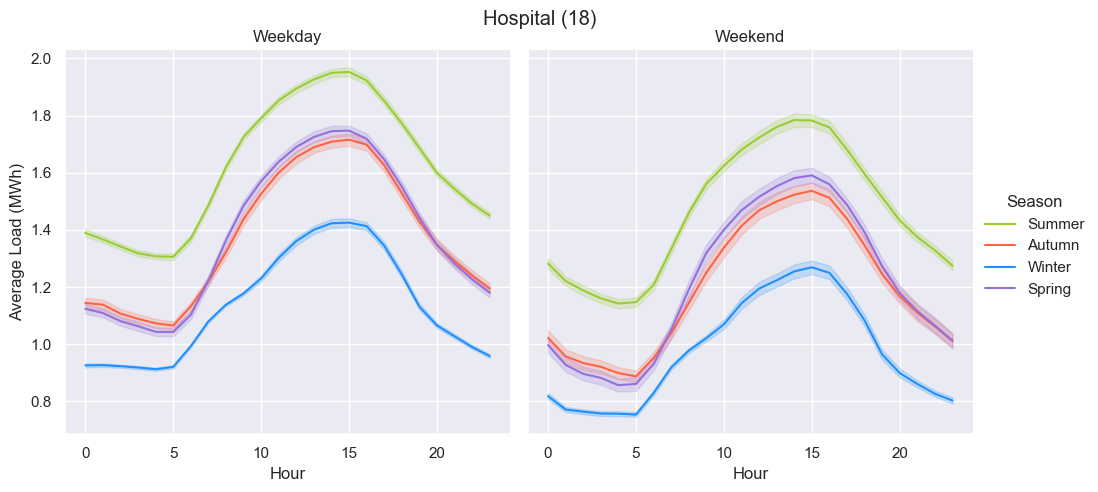

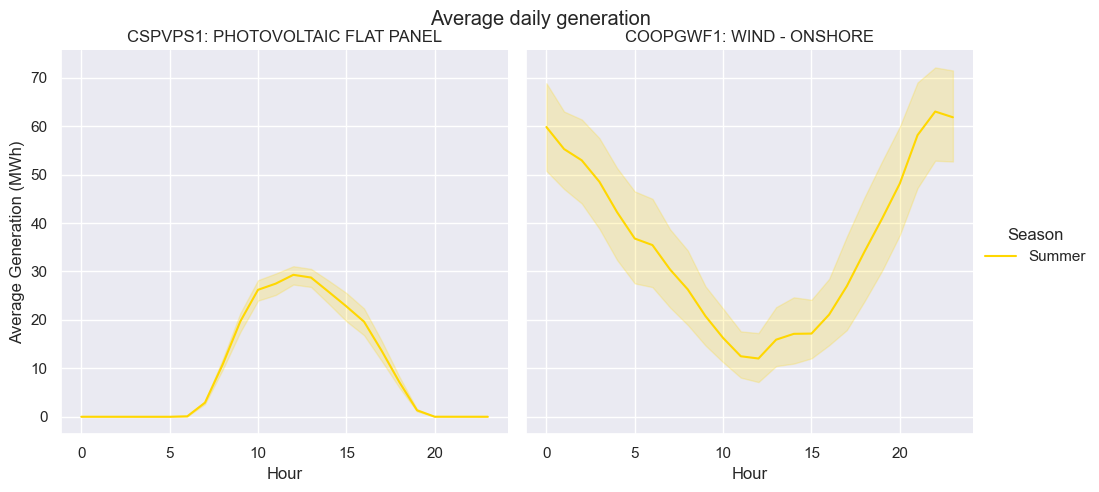

In [40]:
from ppa_analysis import charts, helper_functions

charts.plot_avg_seasonal_load(
    load_data=load_data,
    load_region='QLD1',
    load_title='Hospital (18)'
)

charts.plot_avg_seasonal_generation(
    gen_data=filtered_gen_data,
    generator_col_names=filtered_gen_data.columns,
    load_region='QLD1'
)

## 2. Firming costs

<div style="width: 600px;">
Functionality is provided for setting the time varying costs of purchasing energy
consumption not covered by the renewable energy generation. This functionality
is provided by the function firming_contracts.choose_firming_type.
</div>

In [41]:
from ppa_analysis import firming_contracts

price_data = firming_contracts.choose_firming_type(
        firming_type='Wholesale exposed',
        time_series_data=price_data
)

price_data.head()

,RRP,Firming price
DateTime,,
2020-01-01 01:00:00,52.119075,52.119075
2020-01-01 02:00:00,51.180633,51.180633
2020-01-01 03:00:00,51.841654,51.841654
2020-01-01 04:00:00,51.313714,51.313714
2020-01-01 05:00:00,48.306674,48.306674


## 3. LCOE calculations

<div style="width: 600px;">
The PPA analysis tool includes functionality for calculating renewable generator's levelised cost of electricity (LCOE). The LCOE is then used when running the optimisation that underpins the matching functionality, with the cost procuring energy from a particular generator in the optimisation being set to the generators LCOE. 
</div>

In [42]:
# There is default generator data for calculating LCOE stored in the tool's
# advanced settings module.

from pprint import pprint

low_cost_scen_data = advanced_settings.GEN_COST_DATA['GenCost 2018 Low']

pprint(low_cost_scen_data)


{'Photovoltaic Flat Panel': {'Capacity Factor': 0.22,
                             'Capital ($/kW)': 1280,
                             'Construction Time (years)': 1.0,
                             'Economic Life (years)': 25,
                             'Fixed O&M ($/kW)': 14.4,
                             'Variable O&M ($/kWh)': 0.0},
 'Wind': {'Capacity Factor': 0.35,
          'Capital ($/kW)': 2005,
          'Construction Time (years)': 1.2,
          'Economic Life (years)': 25,
          'Fixed O&M ($/kW)': 36.0,
          'Variable O&M ($/kWh)': 0.0027}}


In [43]:
# Now, we need to create a generator data dictionary with data for each of
# the generators we want to include in the analysis. Here, we'll just use the 
# of the same generators we fetched generation data for before, and give them
# default cost from the advanced_settings module.

generator_cost_data = {}

generator_cost_data['CSPVPS1: PHOTOVOLTAIC FLAT PANEL'] = \
    low_cost_scen_data['Photovoltaic Flat Panel']

generator_cost_data['COOPGWF1: WIND - ONSHORE'] = \
    low_cost_scen_data['Wind']


In [44]:
# We can then call get_all_lcoes from the helper functions to calculate each
# generators LCOE based on its cost data and capacity factor.

from ppa_analysis import helper_functions

lcoe_data = helper_functions.get_all_lcoes(generator_cost_data)

lcoe_data


{'CSPVPS1: PHOTOVOLTAIC FLAT PANEL': 60.98281672136966,
 'COOPGWF1: WIND - ONSHORE': 60.8932904824764}

## 4. Contract optimisation

<div style="width: 600px;">
This section details how to use the PPA analysis functionality to find a mix of 
capacity to contract from a set of renewable energy generators that will result
in a combined generation profile that is well-matched to the load profile and 
minimises costs, and that 
generation is bought at LCOE and that load not by the renewable generators 
is purchased at the wholesale spot price.
</div>
<br>
<div style="width: 600px;">
Just the basic usage of the function hybrid.create_hybrid_generation, which is used 
to run the optimisation, is demonstrated here. The user can read the documentation 
strings of the functions hybrid_pap, hybrid_pac, hybrid_shaped, hybrid_baseload, and hybrid_247 to see the optimisation details for each PPA contract type. The user can 
also read the documentation for hybrid.run_hybrid_optimisation, to see further optimisation implementation details. 
</div>



In [45]:
# First, let's check our load data cover's the time period we've got price
# and generation data for.
print(first_load_timestamp)
print(last_load_timestamp)

2019-01-02 00:00:00
2024-01-01 00:00:00


In [46]:
# We loaded price and generation data for a day in 2020, so we will have load
# data that overlaps with the generation and price data.

In [47]:
# Then, we combine time series load, generation, and price data into a single 
# DataFrame.

time_series_data = price_data.join(load_data)
time_series_data = time_series_data.join(filtered_gen_data)

time_series_data.head()

,RRP,Firming price,Load,CSPVPS1: PHOTOVOLTAIC FLAT PANEL,COOPGWF1: WIND - ONSHORE
DateTime,,,,,
2020-01-01 01:00:00,52.119075,52.119075,1.417109,0.0,82.488179
2020-01-01 02:00:00,51.180633,51.180633,1.342925,0.0,77.129198
2020-01-01 03:00:00,51.841654,51.841654,1.387736,0.0,80.869461
2020-01-01 04:00:00,51.313714,51.313714,1.349911,0.0,68.187557
2020-01-01 05:00:00,48.306674,48.306674,1.311160,0.0,58.687316


In [48]:
# Now, we are ready to run the optimisation.

from ppa_analysis import hybrid

time_series_with_contracted_energy, contracted_percentages = hybrid.create_hybrid_generation(
        contract_type='Pay as Produced',
        contracted_amount=110,
        time_series_data=time_series_data,
        generator_info=lcoe_data
)


In [49]:
# The results indicate the best match of generation to load is achieved by 
# contracting 3.1 % of the wind generator's capacity and 7.1 % of the solar 
# generator's capacity. Of the total volume supplied 61.5 % is from wind and
# 38.5 % is from solar.

pprint(contracted_percentages)

{'COOPGWF1: WIND - ONSHORE': {'Percent of generator output': 3.1330845192089223,
                              'Percent of hybrid trace': 61.50418265415032},
 'CSPVPS1: PHOTOVOLTAIC FLAT PANEL': {'Percent of generator output': 7.105461844101766,
                                      'Percent of hybrid trace': 38.49581734584971}}


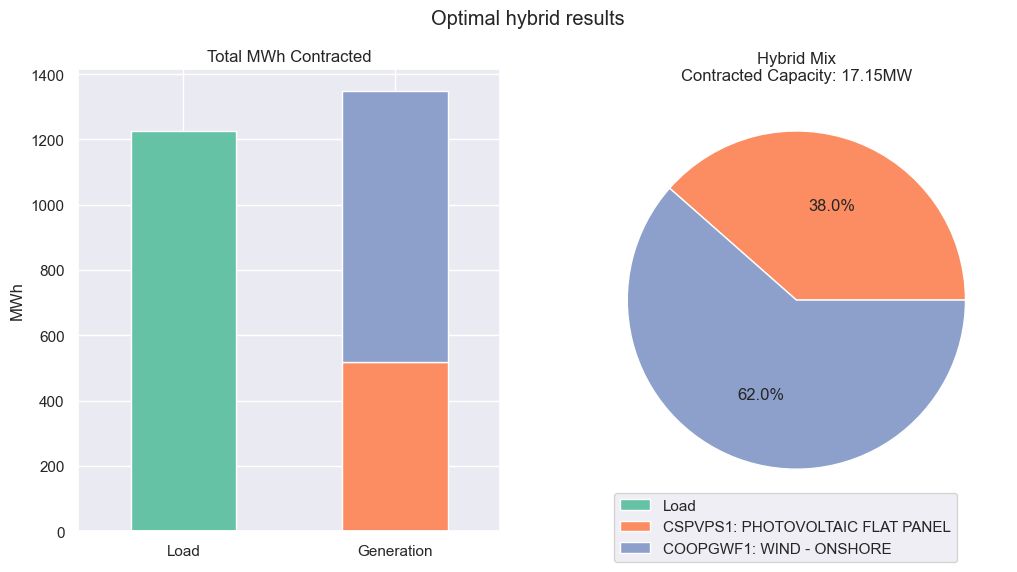

In [50]:
# And we can visualise this result by calling another built-in chart function 
# here to compare the optimised portfolio against the load.

charts.plot_hybrid_results(
    time_series_with_contracted_energy, 
    contracted_percentages, 
    unit_capacities
)

In [51]:
# hybrid.create_hybrid_generation also returns the input time series data with
# additional columns 'Hybrid', indicating the combined renewable energy 
# generation profile, and 'Contracted Energy', indicating the total energy the 
# buyer would purchase under this scenario. In the case of the Pay as Produced
# contract the 'Hybrid' and 'Contracted Energy' volumes are the same.

time_series_with_contracted_energy.head()

,RRP,Firming price,Load,CSPVPS1: PHOTOVOLTAIC FLAT PANEL,COOPGWF1: WIND - ONSHORE,Hybrid,Contracted Energy
DateTime,,,,,,,
2020-01-01 01:00:00,52.119075,52.119075,1.417109,0.0,82.488179,2.584424,2.584424
2020-01-01 02:00:00,51.180633,51.180633,1.342925,0.0,77.129198,2.416523,2.416523
2020-01-01 03:00:00,51.841654,51.841654,1.387736,0.0,80.869461,2.533709,2.533709
2020-01-01 04:00:00,51.313714,51.313714,1.349911,0.0,68.187557,2.136374,2.136374
2020-01-01 05:00:00,48.306674,48.306674,1.311160,0.0,58.687316,1.838723,1.838723


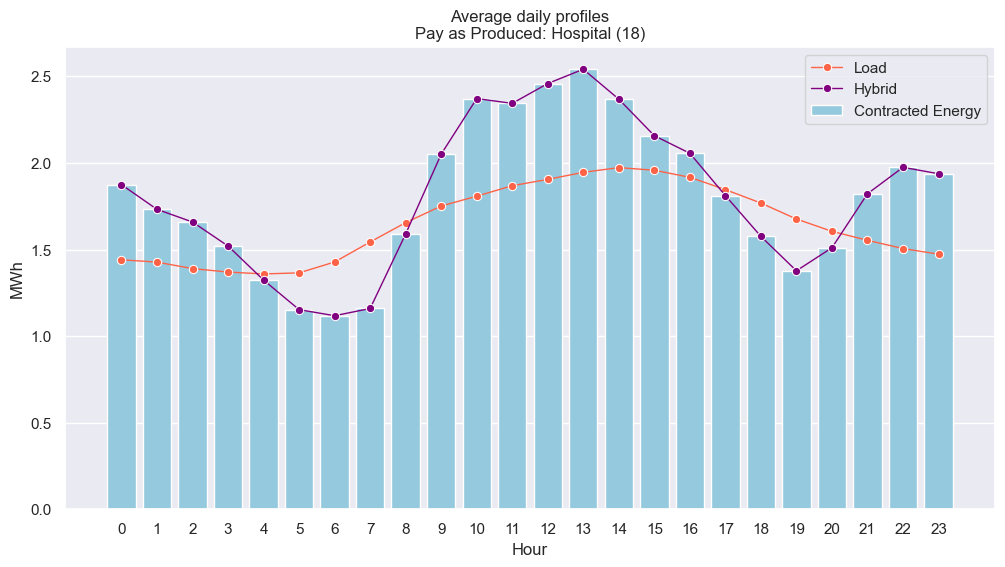

In [52]:
# We can also chart an average day of the load, hybrid and contracted energy
# to visualise the shapes of each more clearly:

charts.plot_contract_samples(
    time_series_with_contracted_energy,
    contract_type='Pay as Produced',
    load_title='Hospital (18)',
    columns_to_plot=['Load']
)

## 5. Battery operation

<div style="width: 600px;">
The PPA analysis tool also includes functionality for optimising battery operation 
to minimise the cost of purchasing energy not covered by the contracted renewable energy
generation. Here, we demonstrate the use of this functionality using the function
battery.run_battery_optimisation and the resulting time series data from the contract
optimisation performed above.
</div>


In [53]:
from ppa_analysis import battery

time_series_data_with_battery = battery.run_battery_optimisation(
        timeseries_data=time_series_with_contracted_energy,
        rated_power_capacity=1,
        size_in_mwh=4
)

Cbc3007W No integer variables


In [54]:
# We'll just add an extra column to help the reader see when the battery 
# charges and discharges.
time_series_data_with_battery['Battery Dispatch'] = \
    time_series_data_with_battery['Load'] - \
    time_series_data_with_battery['Load with battery']

time_series_data_with_battery.head(24)

,RRP,Firming price,Load,CSPVPS1: PHOTOVOLTAIC FLAT PANEL,COOPGWF1: WIND - ONSHORE,Hybrid,Contracted Energy,Load with battery,Battery Dispatch
DateTime,,,,,,,,,
2020-01-01 01:00:00,52.119075,52.119075,1.417109,0.000000,82.488179,2.584424,2.584424,1.417109,0.000000
2020-01-01 02:00:00,51.180633,51.180633,1.342925,0.000000,77.129198,2.416523,2.416523,1.342925,0.000000
2020-01-01 03:00:00,51.841654,51.841654,1.387736,0.000000,80.869461,2.533709,2.533709,1.387736,0.000000
2020-01-01 04:00:00,51.313714,51.313714,1.349911,0.000000,68.187557,2.136374,2.136374,1.349911,0.000000
2020-01-01 05:00:00,48.306674,48.306674,1.311160,0.000000,58.687316,1.838723,1.838723,1.311160,0.000000
2020-01-01 06:00:00,47.867489,47.867489,1.390990,0.211250,57.511213,1.816885,1.816885,1.390990,0.000000
2020-01-01 07:00:00,33.514092,33.514092,1.556107,3.532417,60.509716,2.146815,2.146815,1.556107,0.000000
2020-01-01 08:00:00,30.953977,30.953977,1.693151,14.135833,61.314652,2.925456,2.925456,1.693151,0.000000
2020-01-01 09:00:00,15.922192,15.922192,1.782791,25.173583,44.464554,3.181811,3.181811,1.782791,0.000000


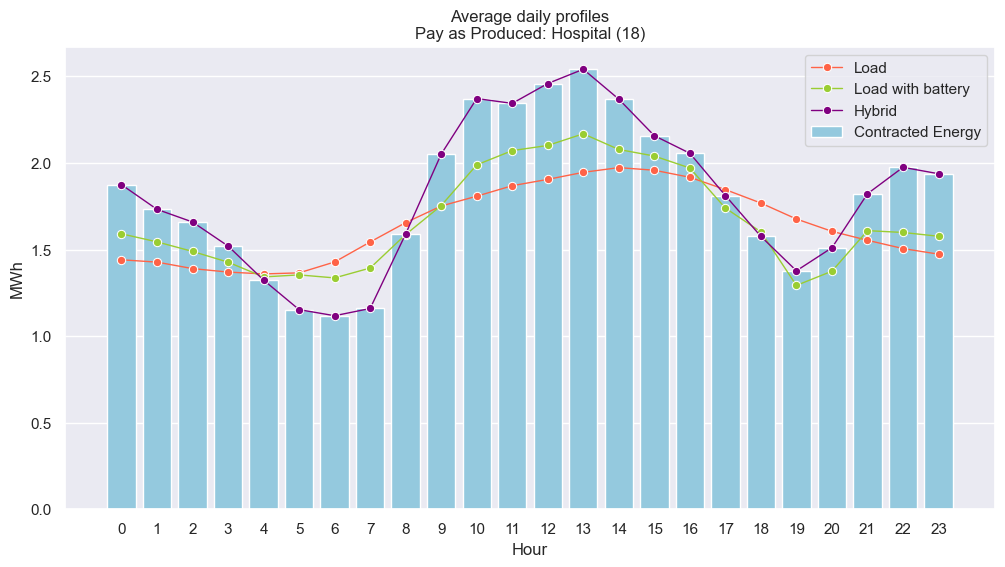

In [55]:
# We can use the same daily average plot as above to see what the battery is 
# doing visually:

charts.plot_contract_samples(
    time_series_data_with_battery,
    contract_type='Pay as Produced',
    load_title='Hospital (18)',
    columns_to_plot=['Load', 'Load with battery']
)

## 6. Load flexibility

<div style="width: 600px;">
Additionally, the PPA analysis tool also includes functionality for optimising load flexibility 
operation to minimise the cost of purchasing energy not covered by the contracted renewable energy
generation. Here, we demonstrate the use of this functionality using the function
load_flex.daily_load_shifting and the time series data from the contract
optimisation performed above.
</div>
<br>
<div style="width: 600px;">
Load flexibility is modelled by calculating a baseload profile for each day which cannot be shifted, with the
remaining flexible load being dispatched across the day to minimise the cost of purchasing energy at the wholesale
price. The baseload profile is calculated by specifying a quantile. Then, on a monthly basis, a daily baseload profile is 
defined by taking the quantile of the load consumption for each hour in the day across the month, with weekdays and 
weekends profiles created separately. For example, if the quantile 0.5 were specified, then for each hour in the day
the median consumption for that hour across the month would be used as the consumption in the monthly baseload profile.
Additionally, before a baseload profile is used to calculate a particular day's
load shifting, if the consumption of the baseload falls below the actual generation for any hour, then the baseload
profile is reset to the actual generation for that hour.
</div>

In [56]:
# First, let's adjust the time series data to account for the battery charge
# and discharge, this step could be skipped if a battery wasn't modelled OR if 
# your goal is to compare the battery against load flex.

# time_series_data_with_battery['Load'] = \
#     time_series_data_with_battery['Load with battery']


In [57]:
# And then we can run the load shifting optimisation.

from ppa_analysis import load_flex

time_series_data_with_load_flex, load_flex_details = load_flex.daily_load_shifting(
        timeseries_data=time_series_data_with_battery,
        base_load_quantile=0.10,
        lower_price=0.0,
        ramp_up_price=0.01,
        ramp_down_price=0.01
)

time_series_data_with_load_flex.head(24)

,RRP,Firming price,Load,CSPVPS1: PHOTOVOLTAIC FLAT PANEL,COOPGWF1: WIND - ONSHORE,Hybrid,Contracted Energy,Load with battery,Battery Dispatch,Load with flex
DateTime,,,,,,,,,,
2020-01-01 01:00:00,52.119075,52.119075,1.417109,0.000000,82.488179,2.584424,2.584424,1.417109,0.000000,1.723330
2020-01-01 02:00:00,51.180633,51.180633,1.342925,0.000000,77.129198,2.416523,2.416523,1.342925,0.000000,1.723330
2020-01-01 03:00:00,51.841654,51.841654,1.387736,0.000000,80.869461,2.533709,2.533709,1.387736,0.000000,1.723330
2020-01-01 04:00:00,51.313714,51.313714,1.349911,0.000000,68.187557,2.136374,2.136374,1.349911,0.000000,1.723330
2020-01-01 05:00:00,48.306674,48.306674,1.311160,0.000000,58.687316,1.838723,1.838723,1.311160,0.000000,1.723330
2020-01-01 06:00:00,47.867489,47.867489,1.390990,0.211250,57.511213,1.816885,1.816885,1.390990,0.000000,1.723330
2020-01-01 07:00:00,33.514092,33.514092,1.556107,3.532417,60.509716,2.146815,2.146815,1.556107,0.000000,1.723330
2020-01-01 08:00:00,30.953977,30.953977,1.693151,14.135833,61.314652,2.925456,2.925456,1.693151,0.000000,1.723330
2020-01-01 09:00:00,15.922192,15.922192,1.782791,25.173583,44.464554,3.181811,3.181811,1.782791,0.000000,1.723330


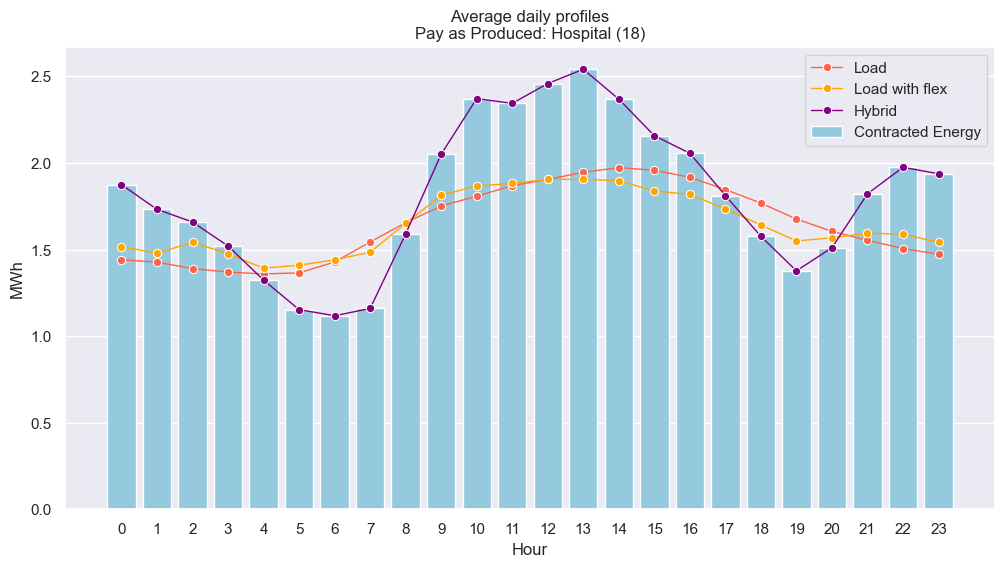

In [58]:
# And again we can visualise the load flex behaviour with the average daily chart
# and compare with the battery behaviour:

charts.plot_contract_samples(
    time_series_data_with_load_flex,
    contract_type='Pay as Produced',
    load_title='Hospital (18)',
    columns_to_plot=['Load', 'Load with flex']
)



## 7. Bill calculation

<div style="width: 600px;">
Finally, the PPA analysis tool provides functionality for calculating the bills associated with a PPA contract.
This functionality is demonstrated below using the output from the contract optimisation and the function
bill_calc.calculate_bill. Note, this function expects the columns 'Load', 'Contracted Energy', 'RRP', 
'Firming price' and the column 'Hybrid' if a contract_type of 'Baseload' or 'Shaped'. Therefore, if the outputs
of the battery or load optimisation are to be used, the 'Load' column may need to be re-calculated, and should
be the original load, net any battery or load dispatch.
</div>

In [59]:
# First, we need to fetch and specify a Network tariff to use in this bill calculation.
# We will use an anytime demand tariff set by Ergon (a DNSP in QLD). The full
# range of tariff options is available in the 'Large_Commercial_23_24.json' file.

tariff_name = 'EDSTT2 Demand Small East'
selected_tariff = helper_functions.get_selected_tariff(
    chosen_tariff=tariff_name, 
    extra_charges_collector={}
)

In [60]:
from ppa_analysis import bill_calc

bill = bill_calc.calculate_bill(
    volume_and_price=time_series_with_contracted_energy,
    settlement_period='Y',
    firming_type='Wholesale exposed',
    tariff_details={'Network':selected_tariff},
    contract_type='Pay as Produced',
    strike_price=75.0,
    lgc_buy_price=10.0,
    lgc_sell_price=10.0,
    shortfall_penalty=50.0,
    guaranteed_percent=90.0,
    excess_price='Wholesale',
    indexation=1.0,
    index_period='Y',
    floor_price= -1000.0
)

bill

,PPA Value,PPA Settlement,PPA Final Cost,Firming Costs,Network Costs,Revenue from on-sold RE,Revenue from excess LGCs,Cost of shortfall LGCs,Shortfall Payments Received,Total
DateTime,,,,,,,,,,
2020-12-31,102127.35446,16195.112512,102127.35446,13150.479182,36854.708739,-19511.754025,-2451.301637,0.0,-0.0,130169.486719


In [61]:
# Users can also calculate a 'bill' or costs to simply purchase all of the 
# equivalent load energy from the wholesale market:
wholesale_bill = bill_calc.calculate_wholesale_bill(
    time_series_with_contracted_energy,
    settlement_period='Y',
    lgc_buy_price=10.0
)

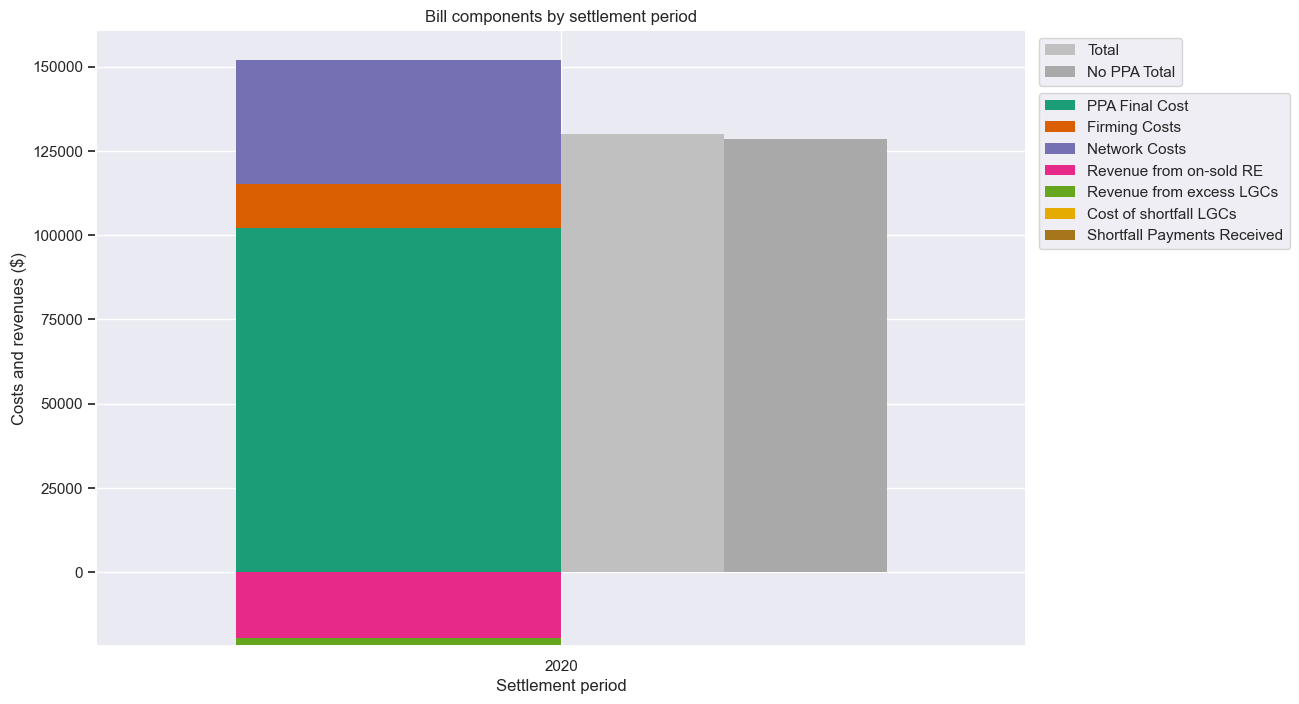

In [62]:
# We can chart the bill results in two ways: a bar chart, allowing for comparison
# between individual components across time periods and against the cost of 
# procurement purely on the wholesale market:

charts.plot_bill_components(
    bill_results=bill.astype(float),
    wholesale_bill_results=wholesale_bill.astype(float),
    settlement_period='Y',
)

# Or as a waterfall chart to view cashflows:
charts.plot_cashflow(bill_results=bill.astype(float))

                      Time  Hourly match (%) - Load  \
DateTime                                              
2020-01-01 01:00:00  01:00                    100.0   
2020-01-01 02:00:00  02:00                    100.0   
2020-01-01 03:00:00  03:00                    100.0   
2020-01-01 04:00:00  04:00                    100.0   
2020-01-01 05:00:00  05:00                    100.0   

                     Hourly match (%) - Load with battery  \
DateTime                                                    
2020-01-01 01:00:00                                 100.0   
2020-01-01 02:00:00                                 100.0   
2020-01-01 03:00:00                                 100.0   
2020-01-01 04:00:00                                 100.0   
2020-01-01 05:00:00                                 100.0   

                     Hourly match (%) - Load with flex  
DateTime                                                
2020-01-01 01:00:00                              100.0  
2020-01-01 02:0

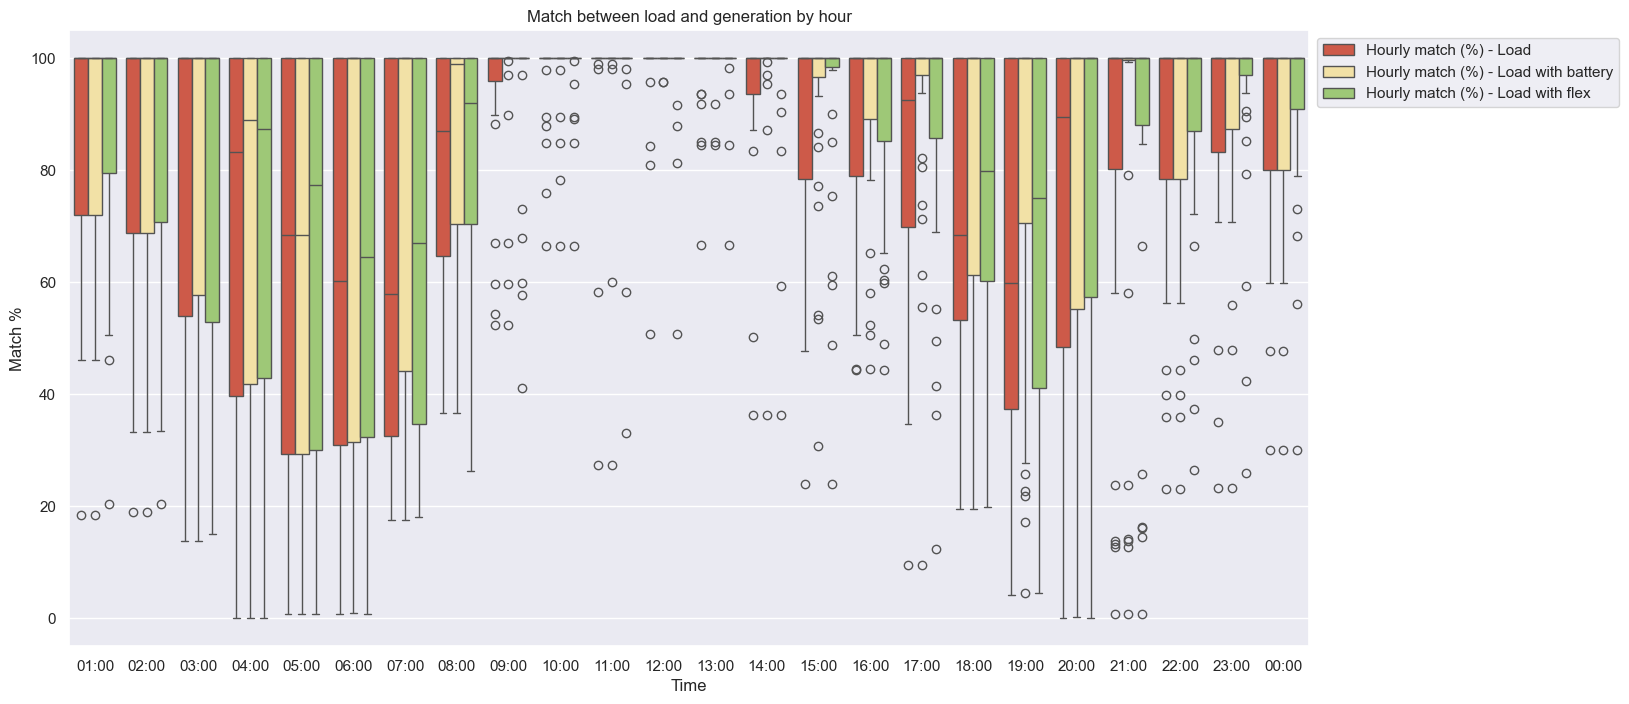

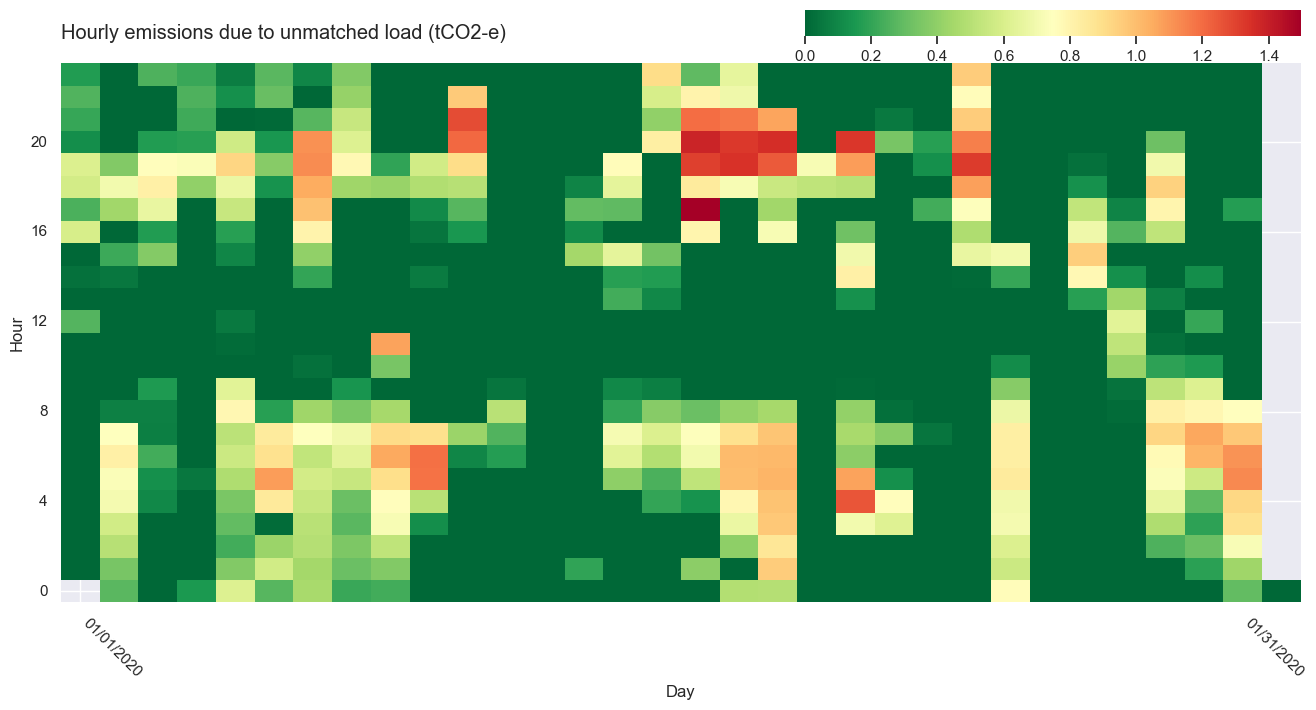

In [ ]:
# As additional potential features of interest, users can chart hourly emissions
# and/or matching in two ways. First, we add a column to the time_series dataframe
# that we wish to visualise that contains emissions data fetched earlier:
time_series_data_with_load_flex['AEI'] = emissions_data['AEI'].copy()

# As box and whisker plots to show the hourly characteristics of each property:
charts.plot_matching_bw(time_series_data_with_load_flex)


# Or as heatmaps to see the full range of results across the whole time period 
# modelled:
charts.plot_emissions_heatmap(time_series_data_with_load_flex, 'Load')
